In [132]:
import torch
from torch.autograd import Variable
import numpy as np
from scipy.stats import truncnorm
import random
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
dtype = torch.FloatTensor

epoch_for_train=1000 #How long to train
samples_per_epoch=250 #The playground.tensorflow.org has 250 train points (and 250 for test)
train_batch_size = 10 #10 as at the playground
summary_every_epoch = 100 #print loss
layers_sizes = [8, 8, 8, 8, 1] #network configuration: every value is layer size


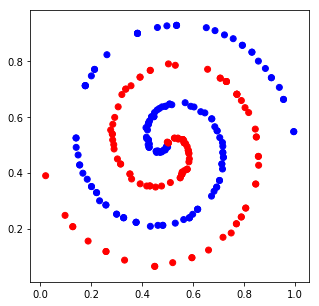

In [133]:
#generating data function - some derivative from playground code
def generate_data(num_of_data):
    xs = np.zeros((num_of_data, 2))
    ys = np.zeros((num_of_data, 1))
    noise=0.01
    size=1

    for i in range(int(num_of_data)):
        if (i%2):    #positive examples
            r = i / num_of_data/2 * size;
            t = 1.75 * i / num_of_data  * math.pi*2;
            xs[i][0] = size/2+r * math.sin(t) + (random.random()-0.5) * noise;
            xs[i][1] = size/2+r * math.cos(t) + (random.random()-0.5) * noise;
            ys[i][0] = 1
        else: #negative examples
            r = i / num_of_data/2 * size;
            t = 1.75 * i / num_of_data  * math.pi*2 +math.pi;
            xs[i][0] = size/2+r * math.sin(t) + (random.random()-0.5) * noise;
            xs[i][1] = size/2+r * math.cos(t) + (random.random()-0.5) * noise;
            ys[i][0] = 0
    return xs, ys


#let's generate: data_x(samples_per_epoch,2) with coordinates of point and data_y(samples_per_epoch,1) with value
data_x, data_y=generate_data(samples_per_epoch)

#function to feed dictionary. Returns a random points from generated data as arrays with batch_size len
dict_index=0
def feed_my_dict(x,y_,batch_size):
    global dict_index
    xs = np.zeros((batch_size, 2))
    ys = np.zeros((batch_size, 1))
    for i in range(batch_size):
        dict_index=int(round(random.random()*(len(data_x[:,0])-1)))
        xs[i][0] = data_x[dict_index,0]
        xs[i][1] = data_x[dict_index,1]
        ys[i][0] = data_y[dict_index,0]
    return {x: xs, y_: ys}


#let's draw generated data
fig, ax = plt.subplots(figsize=(5,5))

#For whole epoch 
for j in range(int(samples_per_epoch/train_batch_size)):
    my_x="x"
    my_y="y"
    #call function that is used for feed tensorflow (to verify it)
    feed_dict=feed_my_dict(my_x,my_y,train_batch_size)
    colors = []
    #to colorize data find max and min y in data
    y_max=np.max(feed_dict[my_y][:,0])
    y_min=np.min(feed_dict[my_y][:,0]) 
    if (y_max!=y_min):
        for i in range(len(feed_dict[my_y][:,0])):#for all batch
            output=(feed_dict[my_y][i,0]-y_min)/(y_max-y_min) #create normalised to 0-1 value
            colors.append((int(output),0,int(1-output)))#color: R-part max when data is '1', B-part max when 0. G always 0
        ax.scatter(feed_dict[my_x][:,0], feed_dict[my_x][:,1], color=colors) #plot all batch points
plt.show()

0.28482605682326245
0.22135458728349122
0.20008085841191686
0.17277749242225207
0.11132563056290502
0.047831558796194926
0.017977043704053168
0.01247785947576613
0.0076145385456131
0.021224779593456852


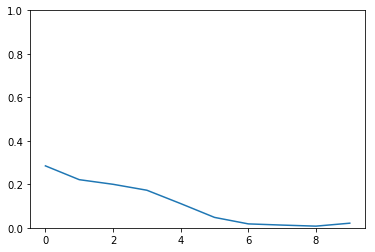

In [142]:
all_weights = []
all_outputs = []
all_biases = []


#generates random with normal distribution and clipped by -1 and 1
def trunc_norm(shape):
    myclip_a = -1
    myclip_b = 1
    my_mean = 0
    my_std = 0.5
    a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std
    return truncnorm.rvs(a, b, scale = my_std, size=shape)
    

#init
for n in range(len(layers_sizes)):
    if (n==0):
        weights_shape = (2, layers_sizes[n])
    else:
        weights_shape = (layers_sizes[n-1],layers_sizes[n])
    weights_np=trunc_norm(weights_shape)
    weights=Variable(torch.from_numpy(weights_np), requires_grad=True)
    biases = Variable(torch.DoubleTensor(layers_sizes[n]).fill_(0.1), requires_grad=True)
    all_weights.append(weights)
    all_biases.append(biases)
    all_outputs.append(np.zeros(layers_sizes[n]))
    

def nn_forward(batch):
    #forward
    for n in range(len(layers_sizes)):
        if (n==0):
            layer_input = Variable(torch.from_numpy(np.array(batch)), requires_grad=False)
        else:
            layer_input= all_outputs[n-1]
        all_outputs[n]=(layer_input.mm(all_weights[n]) + all_biases[n]).clamp(min=0)
    return all_outputs


#Traning
loss_pic=[]
x = "my_x"
y_ = "my_y"
for i in range(epoch_for_train):
    if ((i % summary_every_epoch) == 0):#print loss
        feed_dict=feed_my_dict(x,y_,samples_per_epoch)
        my_outputs_pt=nn_forward(feed_dict[x])
        y_pred=my_outputs_pt[len(layers_sizes)-1]
        loss = (Variable(torch.from_numpy(feed_dict[y_]),requires_grad=False) - y_pred).pow(2).mean()
        loss_np=loss.data[0]
        loss_pic.append(loss_np)
        print(loss_np)

    for j in range(int(samples_per_epoch/train_batch_size)):#one train_step run one batch data
        feed_dict=feed_my_dict(x,y_,train_batch_size)
        my_outputs_pt=nn_forward(feed_dict[x])
        y_pred=my_outputs_pt[len(layers_sizes)-1]
        loss = (Variable(torch.from_numpy(feed_dict[y_]),requires_grad=False) - y_pred).pow(2).mean()

        loss.backward()
        for n in range(len(layers_sizes)):
            leaning_rate=0.05
            all_weights[n].data -= leaning_rate*(all_weights[n].grad.data)
            all_biases[n].data -= leaning_rate*(all_biases[n].grad.data)
            all_weights[n].grad.data.zero_()
            all_biases[n].grad.data.zero_()

#let's draw loss
fig, ax = plt.subplots()
ax.plot(loss_pic) #plot all batch points
ax.set_ylim([0,1])
plt.show()

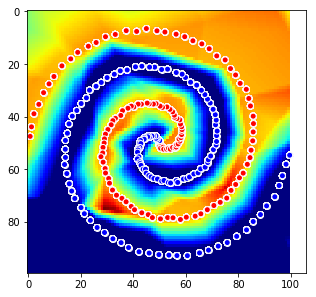

In [143]:
#let's try to draw output picture as at the playground. To do this create a grid as input data
#and give it to our model for calculating 'y' (output). Given 'y' we can draw picture of activation


#special feed dictionry for this - simple grid with some dimension
def feed_dict_for_plot(x,y_,dimension):   
    xs = np.zeros((dimension*dimension, 2))
    ys = np.zeros((dimension*dimension, 1))
    index = 0
    for i in range(dimension):
        for j in range(dimension):
            xs[index][0] = i / dimension
            xs[index][1] = j / dimension
            ys[index][0] = 0 #we do not train the model, so we don't define labels
            index += 1
    return {x: xs, y_: ys}

#resolution for our picture
image_size=100
#feed model our grid
#returned array shape is (image_size^2, 1)
x = "my_x"
y_ = "my_y"
feed_dict=feed_dict_for_plot(x,y_,image_size)
my_outputs_pt=nn_forward(feed_dict[x])
            
my_outputs=[]
for n in range(len(layers_sizes)):
    my_outputs.append(my_outputs_pt[n].data.numpy().T);

output_activation=my_outputs[len(layers_sizes)-1][0]

#Making rgb picture from output data
def out_data_to_rgb(my_y,dimension):
    y_max=np.max(my_y)
    if (y_max==0):
        y_max=0.1
    my_data=cm.jet(my_y/y_max)[:,0:3]
    out_picture=np.reshape(my_data,(dimension,dimension,3))
    out_picture=np.transpose(out_picture,(1,0,2))
    return out_picture


#let's draw output
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(out_data_to_rgb(output_activation,image_size))
#finaly add our dataset at the top of picture as reference
colors = []
y_max=np.max(data_y[:,0])
y_min=np.min(data_y[:,0])   
for i in range(len(data_y[:,0])):
    output=(data_y[i,0]-y_min)/(y_max-y_min)
    colors.append((int(output),0,int(1-output)))
    ax.scatter(data_x[:,0]*image_size, data_x[:,1]*image_size, color=colors, edgecolors ='w')
plt.show()




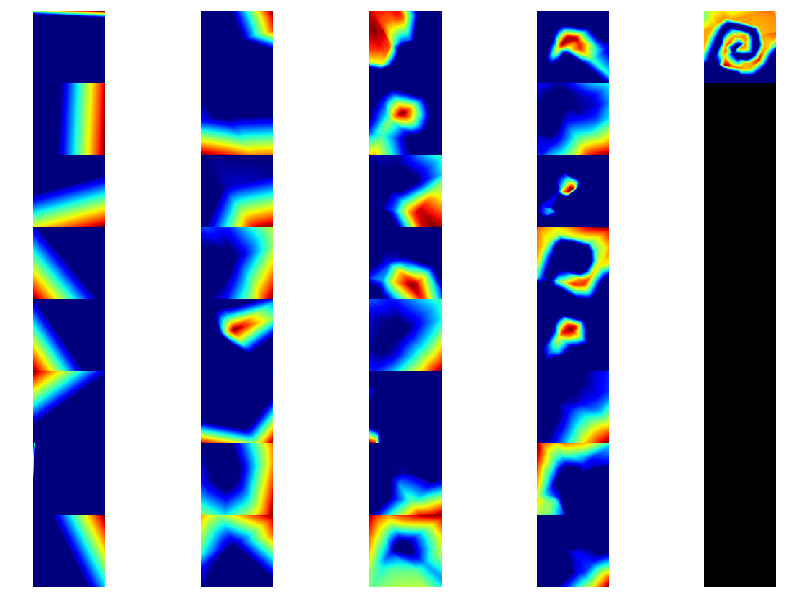

In [144]:
image_data = []
image_num=0
fig = plt.figure(figsize=(len(layers_sizes)*3, max(layers_sizes)))
gs1 = gridspec.GridSpec(max(layers_sizes), len(layers_sizes))
gs1.update(wspace=0.01, hspace=0.0) # set the spacing between axes.
fig.subplots_adjust(bottom=0.0,  top=1, wspace=0, hspace=0)

for n in range(len(layers_sizes)):# by layers
    for m in range(max(layers_sizes)): #by neurons
        image_num=len(layers_sizes)*m+n
        ax = plt.subplot(gs1[image_num])
        if (m<layers_sizes[n]):
            output_activation=my_outputs[n][m]
            ax.imshow(out_data_to_rgb(output_activation,image_size))
        else:
            ax.imshow(np.zeros([image_size, image_size, 3]))
        ax.axis('off')  # clear x- and y-axes

plt.show()
